<a href="https://colab.research.google.com/github/CalistDsouza/MAPD713Assign-1/blob/main/Emerging_Tech_Final_Completed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bhavikjikadara/e-commerce-products-images

Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/e-commerce-products-images
License(s): Attribution 4.0 International (CC BY 4.0)


In [ ]:
import zipfile

with zipfile.ZipFile("/content/e-commerce-products-images.zip", "r") as zip_ref:
    zip_ref.extractall("/content/dataset")

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
import os
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

In [ ]:
df = pd.read_csv('/content/dataset/styles.csv', on_bad_lines="skip")

df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [ ]:
df = df.dropna(subset=["masterCategory"])
df["image"] = df["id"].astype(str) + ".jpg"
df = df[df["image"].apply(lambda x: os.path.isfile(f"/content/dataset/e-commerce/images/{x}"))]

In [ ]:
df.head(20)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


In [ ]:
df['masterCategory'].value_counts(dropna=False)

,count
masterCategory,
Apparel,21395
Accessories,11289
Footwear,9222
Personal Care,2404
Free Items,105
Sporting Goods,25
Home,1


In [ ]:
valid_master_categories = ['Apparel', 'Accessories', 'Footwear', 'Personal Care']
df = df[df['masterCategory'].isin(valid_master_categories)].reset_index(drop=True)

In [ ]:
df['masterCategory'].value_counts(dropna=False)

,count
masterCategory,
Apparel,21395
Accessories,11289
Footwear,9222
Personal Care,2404


In [ ]:
from sklearn.utils import resample

balanced_df = []
for cat in df['masterCategory'].unique():
    subset = df[df['masterCategory'] == cat]
    balanced_subset = resample(subset, n_samples=2400, replace=False, random_state=0)
    balanced_df.append(balanced_subset)

df_balanced = pd.concat(balanced_df).reset_index(drop=True)
df = df_balanced

In [ ]:
df['masterCategory'].value_counts(dropna=False)

,count
masterCategory,
Apparel,2400
Accessories,2400
Footwear,2400
Personal Care,2400


In [ ]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,50541,Men,Apparel,Innerwear,Briefs,Navy Blue,Summer,2016.0,Casual,Chromozome Men Navy Blue Brief,50541.jpg
1,27408,Women,Apparel,Bottomwear,Capris,Grey Melange,Summer,2018.0,Casual,Jockey Women Grey Melange Knit Capris 1300,27408.jpg
2,50463,Men,Apparel,Innerwear,Briefs,Navy Blue,Summer,2016.0,Casual,Chromozome Men Navy Blue Brief,50463.jpg
3,52344,Women,Apparel,Loungewear and Nightwear,Nightdress,Pink,Winter,2015.0,Casual,Red Rose Women Pink Nightdress,52344.jpg
4,45086,Women,Apparel,Loungewear and Nightwear,Night suits,Pink,Winter,2015.0,Casual,Bwitch Pink Orchid Pyjama Set,45086.jpg


In [ ]:
import os

image_dir = "/content/dataset/e-commerce/images"
valid_images = set(df['image'])

deleted_count = 0
for filename in os.listdir(image_dir):
    if filename.endswith('.jpg') and filename not in valid_images:
        file_path = os.path.join(image_dir, filename)
        os.remove(file_path)
        deleted_count += 1

print(f"✅ Deleted {deleted_count} images not in DataFrame.")

✅ Deleted 34841 images not in DataFrame.


In [ ]:
image_count = len([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

print(f"Total images in dataset folder: {image_count}")

Total images in dataset folder: 9600


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
condition_vectors = encoder.fit_transform(df[["masterCategory"]])
df["condition_vector"] = list(condition_vectors)

In [ ]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image,condition_vector
0,50541,Men,Apparel,Innerwear,Briefs,Navy Blue,Summer,2016.0,Casual,Chromozome Men Navy Blue Brief,50541.jpg,"[0.0, 1.0, 0.0, 0.0]"
1,27408,Women,Apparel,Bottomwear,Capris,Grey Melange,Summer,2018.0,Casual,Jockey Women Grey Melange Knit Capris 1300,27408.jpg,"[0.0, 1.0, 0.0, 0.0]"
2,50463,Men,Apparel,Innerwear,Briefs,Navy Blue,Summer,2016.0,Casual,Chromozome Men Navy Blue Brief,50463.jpg,"[0.0, 1.0, 0.0, 0.0]"
3,52344,Women,Apparel,Loungewear and Nightwear,Nightdress,Pink,Winter,2015.0,Casual,Red Rose Women Pink Nightdress,52344.jpg,"[0.0, 1.0, 0.0, 0.0]"
4,45086,Women,Apparel,Loungewear and Nightwear,Night suits,Pink,Winter,2015.0,Casual,Bwitch Pink Orchid Pyjama Set,45086.jpg,"[0.0, 1.0, 0.0, 0.0]"


In [ ]:
import os

old_path = "/content/dataset/styles.csv"
if os.path.exists(old_path):
    os.remove(old_path)
    print("Original file deleted.")
else:
    print("Original file not found.")

Original file deleted.


In [ ]:
df.to_csv("/content/dataset/styles.csv", index=False)

In [ ]:
!zip -r /content/emerging_cleaned_dataset.zip /content/dataset/e-commerce/images > /dev/null

from google.colab import files
files.download("/content/emerging_cleaned_dataset.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

### Master Category Classifier

In [ ]:
class ClassifierDataset(Dataset):
    def __init__(self, df, image_dir, transform, label_encoder):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform
        self.label_encoder = label_encoder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
      row = self.df.iloc[idx]
      image_path = os.path.join(self.image_dir, row["image"])
      image = Image.open(image_path).convert("RGB")
      if self.transform:
          image = self.transform(image)
      cond = torch.tensor(row["condition_vector"], dtype=torch.float32)
      label = torch.tensor(row["masterCategory"], dtype=torch.long)
      return image, cond, label

In [ ]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

label_encoder = LabelEncoder()
df['masterCategory'] = label_encoder.fit_transform(df['masterCategory'])

classifier_dataset = ClassifierDataset(df, image_dir, transform, label_encoder)
classifier_loader = DataLoader(classifier_dataset, batch_size=32, shuffle=True, num_workers=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MasterCategoryClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MasterCategoryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
classifier = MasterCategoryClassifier(num_classes=len(label_encoder.classes_)).to(device)
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [ ]:
best_acc = 0.0
epochs_no_improve = 0
patience = 3
num_epochs = 50

classifier.train()
for epoch in range(num_epochs):
    running_loss = 0
    correct = 0
    total = 0

    for imgs, _, labels in classifier_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classifier(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = correct / total * 100
    avg_loss = running_loss / len(classifier_loader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

    if acc > best_acc + 0.5:
        best_acc = acc
        epochs_no_improve = 0
        torch.save(classifier.state_dict(), "classifier.pt")
        print("Accuracy improved, model saved!")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break


Epoch 1, Loss: 1.0856, Accuracy: 52.11%
Accuracy improved, model saved!
Epoch 2, Loss: 0.6102, Accuracy: 78.20%
Accuracy improved, model saved!
Epoch 3, Loss: 0.4998, Accuracy: 82.71%
Accuracy improved, model saved!
Epoch 4, Loss: 0.3919, Accuracy: 86.62%
Accuracy improved, model saved!
Epoch 5, Loss: 0.3485, Accuracy: 88.46%
Accuracy improved, model saved!
Epoch 6, Loss: 0.3158, Accuracy: 89.76%
Accuracy improved, model saved!
Epoch 7, Loss: 0.2775, Accuracy: 91.14%
Accuracy improved, model saved!
Epoch 8, Loss: 0.2547, Accuracy: 91.85%
Accuracy improved, model saved!
Epoch 9, Loss: 0.2381, Accuracy: 92.23%
No improvement for 1 epoch(s)
Epoch 10, Loss: 0.2202, Accuracy: 93.02%
Accuracy improved, model saved!
Epoch 11, Loss: 0.2019, Accuracy: 93.57%
Accuracy improved, model saved!
Epoch 12, Loss: 0.1969, Accuracy: 93.66%
No improvement for 1 epoch(s)
Epoch 13, Loss: 0.2083, Accuracy: 93.14%
No improvement for 2 epoch(s)
Epoch 14, Loss: 0.1935, Accuracy: 93.55%
No improvement for 3 epoc

In [ ]:
torch.save(classifier.state_dict(), "/content/classifier.pt")

In [ ]:
class FashionDataset(Dataset):
    def __init__(self, df, image_dir, transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row["image"])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        cond = torch.tensor(row["condition_vector"], dtype=torch.float32)
        label = torch.tensor(row["masterCategory"], dtype=torch.long)
        return image, cond, label

image_dir = '/content/dataset/e-commerce/images'
dataset = FashionDataset(df, image_dir, transform)
dataloader = DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

In [ ]:
classifier = MasterCategoryClassifier(num_classes=len(label_encoder.classes_)).to(device)
classifier.load_state_dict(torch.load("/content/classifier.pt"))
classifier.eval()

MasterCategoryClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
label_encoder.classes_

array(['Accessories', 'Apparel', 'Footwear', 'Personal Care'],
      dtype=object)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, condition_dim, latent_dim=256):
        super(CVAE, self).__init__()
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim

        # --- Encoder ---
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        self.fc_mu = nn.Linear(256 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4 + condition_dim, latent_dim)

        # --- Decoder ---
        self.decoder_input = nn.Linear(latent_dim + condition_dim, 256 * 4 * 4)

        # Inject condition into the decoder through the first layer (256 + cond_dim)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256 + condition_dim, 128, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.Sigmoid()
        )

    def encode(self, x, cond):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x_cond = torch.cat([x, cond], dim=1)
        mu = self.fc_mu(x_cond)
        logvar = self.fc_logvar(x_cond)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        z_cond = torch.cat([z, cond], dim=1)
        x = self.decoder_input(z_cond)
        x = x.view(-1, 256, 4, 4)

        # Deep conditioning: broadcast cond and concat
        cond_expand = cond.unsqueeze(2).unsqueeze(3).expand(-1, self.condition_dim, 4, 4)
        x = torch.cat([x, cond_expand], dim=1)

        return self.decoder_conv(x)

    def forward(self, x, cond):
        mu, logvar = self.encode(x, cond)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, cond)
        return recon, mu, logvar

    def sample(self, cond, n_samples=1):
        z = torch.randn(n_samples, self.latent_dim).to(cond.device)
        cond = cond.repeat(n_samples, 1) if cond.dim() == 1 else cond
        return self.decode(z, cond)

In [ ]:
import torch.nn.functional as F

def loss_function(recon_x, x, mu, logvar, labels, lambda_class=3.0, beta=0.001):
    BCE = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    with torch.no_grad():
        classifier.eval()  # Keep classifier frozen
        logits = classifier(recon_x.detach())  # prevent updating classifier, allow grad to flow to CVAE
        class_loss = F.cross_entropy(logits, labels)

    return BCE + beta * KLD + lambda_class * class_loss

In [ ]:
model = CVAE(condition_dim=condition_vectors.shape[1]).to(device)

In [ ]:
import torch.optim as optim

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
from tqdm import tqdm

EPOCHS = 300
PATIENCE = 5
best_loss = float('inf')
epochs_no_improve = 0
warmup_epochs = 40


classifier.eval()

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{EPOCHS}")

    for imgs, cond, labels in pbar:  # Unpack all 3
        imgs = imgs.to(device)
        cond = cond.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(imgs, cond)

        beta = 0.001 * min(1.0, epoch / warmup_epochs)
        loss = loss_function(recon, imgs, mu, logvar, labels, lambda_class=3.0, beta=beta)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = train_loss / len(dataloader)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

    # Early stopping check
    if avg_loss < best_loss - 1e-3:
        best_loss = avg_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("Loss improved, model saved!")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s)")

    if epochs_no_improve >= PATIENCE:
        print("Early stopping triggered!")
        break


Epoch 1/300: 100%|██████████| 300/300 [00:09<00:00, 31.08it/s, loss=3.37e+3]


Epoch 1, Loss: 9793.9153
Loss improved, model saved!


Epoch 2/300: 100%|██████████| 300/300 [00:08<00:00, 34.75it/s, loss=3.76e+3]


Epoch 2, Loss: 3784.2403
Loss improved, model saved!


Epoch 3/300: 100%|██████████| 300/300 [00:07<00:00, 37.51it/s, loss=2.84e+3]


Epoch 3, Loss: 3231.6064
Loss improved, model saved!


Epoch 4/300: 100%|██████████| 300/300 [00:08<00:00, 34.43it/s, loss=2.55e+3]


Epoch 4, Loss: 2851.9293
Loss improved, model saved!


Epoch 5/300: 100%|██████████| 300/300 [00:08<00:00, 34.53it/s, loss=2.19e+3]


Epoch 5, Loss: 2523.7961
Loss improved, model saved!


Epoch 6/300: 100%|██████████| 300/300 [00:07<00:00, 37.98it/s, loss=1.91e+3]


Epoch 6, Loss: 2141.9436
Loss improved, model saved!


Epoch 7/300: 100%|██████████| 300/300 [00:10<00:00, 29.86it/s, loss=2.56e+3]


Epoch 7, Loss: 2381.2497
No improvement for 1 epoch(s)


Epoch 8/300: 100%|██████████| 300/300 [00:08<00:00, 34.31it/s, loss=1.97e+3]


Epoch 8, Loss: 2135.3829
Loss improved, model saved!


Epoch 9/300: 100%|██████████| 300/300 [00:07<00:00, 38.56it/s, loss=1.45e+3]


Epoch 9, Loss: 1877.6568
Loss improved, model saved!


Epoch 10/300: 100%|██████████| 300/300 [00:08<00:00, 33.58it/s, loss=2.3e+3]


Epoch 10, Loss: 1926.9587
No improvement for 1 epoch(s)


Epoch 11/300: 100%|██████████| 300/300 [00:08<00:00, 33.93it/s, loss=1.82e+3]


Epoch 11, Loss: 1890.5363
No improvement for 2 epoch(s)


Epoch 12/300: 100%|██████████| 300/300 [00:07<00:00, 38.06it/s, loss=1.61e+3]


Epoch 12, Loss: 1689.8087
Loss improved, model saved!


Epoch 13/300: 100%|██████████| 300/300 [00:08<00:00, 33.40it/s, loss=1.95e+3]


Epoch 13, Loss: 1628.6208
Loss improved, model saved!


Epoch 14/300: 100%|██████████| 300/300 [00:09<00:00, 33.07it/s, loss=1.34e+3]


Epoch 14, Loss: 1571.7987
Loss improved, model saved!


Epoch 15/300: 100%|██████████| 300/300 [00:08<00:00, 37.27it/s, loss=1.63e+3]


Epoch 15, Loss: 1511.7877
Loss improved, model saved!


Epoch 16/300: 100%|██████████| 300/300 [00:08<00:00, 33.98it/s, loss=1.77e+3]


Epoch 16, Loss: 1523.2874
No improvement for 1 epoch(s)


Epoch 17/300: 100%|██████████| 300/300 [00:08<00:00, 33.49it/s, loss=1.23e+3]


Epoch 17, Loss: 1443.7415
Loss improved, model saved!


Epoch 18/300: 100%|██████████| 300/300 [00:08<00:00, 35.89it/s, loss=1.22e+3]


Epoch 18, Loss: 1405.8221
Loss improved, model saved!


Epoch 19/300: 100%|██████████| 300/300 [00:08<00:00, 36.44it/s, loss=1.63e+3]


Epoch 19, Loss: 1379.1708
Loss improved, model saved!


Epoch 20/300: 100%|██████████| 300/300 [00:08<00:00, 34.00it/s, loss=1.41e+3]


Epoch 20, Loss: 1335.7570
Loss improved, model saved!


Epoch 21/300: 100%|██████████| 300/300 [00:08<00:00, 33.99it/s, loss=1.78e+3]


Epoch 21, Loss: 1290.1119
Loss improved, model saved!


Epoch 22/300: 100%|██████████| 300/300 [00:07<00:00, 38.17it/s, loss=1.29e+3]


Epoch 22, Loss: 1291.3523
No improvement for 1 epoch(s)


Epoch 23/300: 100%|██████████| 300/300 [00:08<00:00, 34.17it/s, loss=1.14e+3]


Epoch 23, Loss: 1228.0914
Loss improved, model saved!


Epoch 24/300: 100%|██████████| 300/300 [00:08<00:00, 33.53it/s, loss=1.39e+3]


Epoch 24, Loss: 1608.7932
No improvement for 1 epoch(s)


Epoch 25/300: 100%|██████████| 300/300 [00:07<00:00, 38.18it/s, loss=1.37e+3]


Epoch 25, Loss: 1280.3095
No improvement for 2 epoch(s)


Epoch 26/300: 100%|██████████| 300/300 [00:08<00:00, 33.54it/s, loss=1.19e+3]


Epoch 26, Loss: 1201.4603
Loss improved, model saved!


Epoch 27/300: 100%|██████████| 300/300 [00:08<00:00, 33.58it/s, loss=1.38e+3]


Epoch 27, Loss: 1171.1506
Loss improved, model saved!


Epoch 28/300: 100%|██████████| 300/300 [00:08<00:00, 37.49it/s, loss=1.06e+3]


Epoch 28, Loss: 1135.8447
Loss improved, model saved!


Epoch 29/300: 100%|██████████| 300/300 [00:08<00:00, 33.66it/s, loss=1.2e+3]


Epoch 29, Loss: 1116.9873
Loss improved, model saved!


Epoch 30/300: 100%|██████████| 300/300 [00:08<00:00, 33.77it/s, loss=1.18e+3]


Epoch 30, Loss: 1085.6529
Loss improved, model saved!


Epoch 31/300: 100%|██████████| 300/300 [00:07<00:00, 37.77it/s, loss=1.23e+3]


Epoch 31, Loss: 1070.6187
Loss improved, model saved!


Epoch 32/300: 100%|██████████| 300/300 [00:09<00:00, 33.17it/s, loss=904]


Epoch 32, Loss: 1043.9013
Loss improved, model saved!


Epoch 33/300: 100%|██████████| 300/300 [00:09<00:00, 33.18it/s, loss=1.04e+3]


Epoch 33, Loss: 1029.7965
Loss improved, model saved!


Epoch 34/300: 100%|██████████| 300/300 [00:07<00:00, 37.82it/s, loss=932]


Epoch 34, Loss: 994.1556
Loss improved, model saved!


Epoch 35/300: 100%|██████████| 300/300 [00:08<00:00, 33.39it/s, loss=1.01e+3]


Epoch 35, Loss: 982.1752
Loss improved, model saved!


Epoch 36/300: 100%|██████████| 300/300 [00:08<00:00, 33.51it/s, loss=910]


Epoch 36, Loss: 959.4985
Loss improved, model saved!


Epoch 37/300: 100%|██████████| 300/300 [00:08<00:00, 35.50it/s, loss=994]


Epoch 37, Loss: 937.6573
Loss improved, model saved!


Epoch 38/300: 100%|██████████| 300/300 [00:08<00:00, 35.58it/s, loss=888]


Epoch 38, Loss: 934.9290
Loss improved, model saved!


Epoch 39/300: 100%|██████████| 300/300 [00:08<00:00, 34.15it/s, loss=1.05e+3]


Epoch 39, Loss: 924.6109
Loss improved, model saved!


Epoch 40/300: 100%|██████████| 300/300 [00:08<00:00, 34.57it/s, loss=831]


Epoch 40, Loss: 894.3118
Loss improved, model saved!


Epoch 41/300: 100%|██████████| 300/300 [00:07<00:00, 37.87it/s, loss=734]


Epoch 41, Loss: 889.2606
Loss improved, model saved!


Epoch 42/300: 100%|██████████| 300/300 [00:09<00:00, 33.29it/s, loss=1.05e+3]


Epoch 42, Loss: 879.9788
Loss improved, model saved!


Epoch 43/300: 100%|██████████| 300/300 [00:08<00:00, 33.87it/s, loss=781]


Epoch 43, Loss: 873.6463
Loss improved, model saved!


Epoch 44/300: 100%|██████████| 300/300 [00:07<00:00, 38.26it/s, loss=920]


Epoch 44, Loss: 844.2916
Loss improved, model saved!


Epoch 45/300: 100%|██████████| 300/300 [00:09<00:00, 33.23it/s, loss=824]


Epoch 45, Loss: 831.6993
Loss improved, model saved!


Epoch 46/300: 100%|██████████| 300/300 [00:08<00:00, 33.53it/s, loss=754]


Epoch 46, Loss: 845.4861
No improvement for 1 epoch(s)


Epoch 47/300: 100%|██████████| 300/300 [00:07<00:00, 37.73it/s, loss=813]


Epoch 47, Loss: 823.0687
Loss improved, model saved!


Epoch 48/300: 100%|██████████| 300/300 [00:08<00:00, 33.73it/s, loss=1.07e+3]


Epoch 48, Loss: 823.5373
No improvement for 1 epoch(s)


Epoch 49/300: 100%|██████████| 300/300 [00:08<00:00, 33.47it/s, loss=772]


Epoch 49, Loss: 793.0252
Loss improved, model saved!


Epoch 50/300: 100%|██████████| 300/300 [00:07<00:00, 37.91it/s, loss=846]


Epoch 50, Loss: 785.0984
Loss improved, model saved!


Epoch 51/300: 100%|██████████| 300/300 [00:08<00:00, 33.91it/s, loss=1.01e+3]


Epoch 51, Loss: 767.4288
Loss improved, model saved!


Epoch 52/300: 100%|██████████| 300/300 [00:08<00:00, 33.37it/s, loss=759]


Epoch 52, Loss: 779.7095
No improvement for 1 epoch(s)


Epoch 53/300: 100%|██████████| 300/300 [00:07<00:00, 38.32it/s, loss=832]


Epoch 53, Loss: 751.8849
Loss improved, model saved!


Epoch 54/300: 100%|██████████| 300/300 [00:08<00:00, 33.70it/s, loss=774]


Epoch 54, Loss: 749.6933
Loss improved, model saved!


Epoch 55/300: 100%|██████████| 300/300 [00:08<00:00, 33.67it/s, loss=676]


Epoch 55, Loss: 742.3198
Loss improved, model saved!


Epoch 56/300: 100%|██████████| 300/300 [00:07<00:00, 37.64it/s, loss=785]


Epoch 56, Loss: 735.3193
Loss improved, model saved!


Epoch 57/300: 100%|██████████| 300/300 [00:08<00:00, 33.40it/s, loss=621]


Epoch 57, Loss: 741.8089
No improvement for 1 epoch(s)


Epoch 58/300: 100%|██████████| 300/300 [00:09<00:00, 33.26it/s, loss=728]


Epoch 58, Loss: 712.7451
Loss improved, model saved!


Epoch 59/300: 100%|██████████| 300/300 [00:08<00:00, 36.28it/s, loss=603]


Epoch 59, Loss: 707.7299
Loss improved, model saved!


Epoch 60/300: 100%|██████████| 300/300 [00:08<00:00, 34.34it/s, loss=633]


Epoch 60, Loss: 696.6456
Loss improved, model saved!


Epoch 61/300: 100%|██████████| 300/300 [00:09<00:00, 32.80it/s, loss=701]


Epoch 61, Loss: 696.0784
Loss improved, model saved!


Epoch 62/300: 100%|██████████| 300/300 [00:08<00:00, 34.84it/s, loss=777]


Epoch 62, Loss: 695.9117
Loss improved, model saved!


Epoch 63/300: 100%|██████████| 300/300 [00:08<00:00, 36.67it/s, loss=639]


Epoch 63, Loss: 683.0562
Loss improved, model saved!


Epoch 64/300: 100%|██████████| 300/300 [00:08<00:00, 33.56it/s, loss=674]


Epoch 64, Loss: 686.0336
No improvement for 1 epoch(s)


Epoch 65/300: 100%|██████████| 300/300 [00:08<00:00, 33.63it/s, loss=660]


Epoch 65, Loss: 672.7504
Loss improved, model saved!


Epoch 66/300: 100%|██████████| 300/300 [00:08<00:00, 37.42it/s, loss=846]


Epoch 66, Loss: 664.5117
Loss improved, model saved!


Epoch 67/300: 100%|██████████| 300/300 [00:08<00:00, 33.45it/s, loss=658]


Epoch 67, Loss: 658.6319
Loss improved, model saved!


Epoch 68/300: 100%|██████████| 300/300 [00:08<00:00, 33.56it/s, loss=587]


Epoch 68, Loss: 650.1921
Loss improved, model saved!


Epoch 69/300: 100%|██████████| 300/300 [00:08<00:00, 35.66it/s, loss=688]


Epoch 69, Loss: 644.2274
Loss improved, model saved!


Epoch 70/300: 100%|██████████| 300/300 [00:09<00:00, 32.30it/s, loss=625]


Epoch 70, Loss: 636.5188
Loss improved, model saved!


Epoch 71/300: 100%|██████████| 300/300 [00:08<00:00, 33.63it/s, loss=539]


Epoch 71, Loss: 641.3305
No improvement for 1 epoch(s)


Epoch 72/300: 100%|██████████| 300/300 [00:08<00:00, 36.89it/s, loss=648]


Epoch 72, Loss: 630.3195
Loss improved, model saved!


Epoch 73/300: 100%|██████████| 300/300 [00:08<00:00, 34.08it/s, loss=664]


Epoch 73, Loss: 630.8174
No improvement for 1 epoch(s)


Epoch 74/300: 100%|██████████| 300/300 [00:08<00:00, 33.44it/s, loss=548]


Epoch 74, Loss: 623.9535
Loss improved, model saved!


Epoch 75/300: 100%|██████████| 300/300 [00:08<00:00, 35.09it/s, loss=663]


Epoch 75, Loss: 622.0594
Loss improved, model saved!


Epoch 76/300: 100%|██████████| 300/300 [00:08<00:00, 35.58it/s, loss=622]


Epoch 76, Loss: 610.1710
Loss improved, model saved!


Epoch 77/300: 100%|██████████| 300/300 [00:08<00:00, 33.50it/s, loss=715]


Epoch 77, Loss: 609.9034
Loss improved, model saved!


Epoch 78/300: 100%|██████████| 300/300 [00:08<00:00, 34.38it/s, loss=610]


Epoch 78, Loss: 604.2535
Loss improved, model saved!


Epoch 79/300: 100%|██████████| 300/300 [00:08<00:00, 36.47it/s, loss=603]


Epoch 79, Loss: 601.2051
Loss improved, model saved!


Epoch 80/300: 100%|██████████| 300/300 [00:09<00:00, 33.04it/s, loss=548]


Epoch 80, Loss: 590.3976
Loss improved, model saved!


Epoch 81/300: 100%|██████████| 300/300 [00:09<00:00, 32.70it/s, loss=480]


Epoch 81, Loss: 589.3294
Loss improved, model saved!


Epoch 82/300: 100%|██████████| 300/300 [00:08<00:00, 37.43it/s, loss=656]


Epoch 82, Loss: 591.0271
No improvement for 1 epoch(s)


Epoch 83/300: 100%|██████████| 300/300 [00:09<00:00, 32.68it/s, loss=613]


Epoch 83, Loss: 579.8635
Loss improved, model saved!


Epoch 84/300: 100%|██████████| 300/300 [00:09<00:00, 33.11it/s, loss=542]


Epoch 84, Loss: 574.0174
Loss improved, model saved!


Epoch 85/300: 100%|██████████| 300/300 [00:08<00:00, 36.80it/s, loss=545]


Epoch 85, Loss: 571.2404
Loss improved, model saved!


Epoch 86/300: 100%|██████████| 300/300 [00:09<00:00, 32.80it/s, loss=625]


Epoch 86, Loss: 575.9791
No improvement for 1 epoch(s)


Epoch 87/300: 100%|██████████| 300/300 [00:09<00:00, 33.09it/s, loss=630]


Epoch 87, Loss: 566.5923
Loss improved, model saved!


Epoch 88/300: 100%|██████████| 300/300 [00:08<00:00, 36.20it/s, loss=567]


Epoch 88, Loss: 558.2980
Loss improved, model saved!


Epoch 89/300: 100%|██████████| 300/300 [00:09<00:00, 33.05it/s, loss=519]


Epoch 89, Loss: 561.5927
No improvement for 1 epoch(s)


Epoch 90/300: 100%|██████████| 300/300 [00:09<00:00, 31.92it/s, loss=496]


Epoch 90, Loss: 553.6471
Loss improved, model saved!


Epoch 91/300: 100%|██████████| 300/300 [00:09<00:00, 32.40it/s, loss=489]


Epoch 91, Loss: 551.3603
Loss improved, model saved!


Epoch 92/300: 100%|██████████| 300/300 [00:08<00:00, 35.56it/s, loss=542]


Epoch 92, Loss: 558.1942
No improvement for 1 epoch(s)


Epoch 93/300: 100%|██████████| 300/300 [00:09<00:00, 32.00it/s, loss=534]


Epoch 93, Loss: 544.9871
Loss improved, model saved!


Epoch 94/300: 100%|██████████| 300/300 [00:09<00:00, 32.37it/s, loss=584]


Epoch 94, Loss: 543.2704
Loss improved, model saved!


Epoch 95/300: 100%|██████████| 300/300 [00:08<00:00, 35.90it/s, loss=549]


Epoch 95, Loss: 542.6928
Loss improved, model saved!


Epoch 96/300: 100%|██████████| 300/300 [00:09<00:00, 32.71it/s, loss=490]


Epoch 96, Loss: 533.6529
Loss improved, model saved!


Epoch 97/300: 100%|██████████| 300/300 [00:09<00:00, 32.24it/s, loss=548]


Epoch 97, Loss: 531.2686
Loss improved, model saved!


Epoch 98/300: 100%|██████████| 300/300 [00:09<00:00, 33.10it/s, loss=476]


Epoch 98, Loss: 525.0938
Loss improved, model saved!


Epoch 99/300: 100%|██████████| 300/300 [00:08<00:00, 35.12it/s, loss=531]


Epoch 99, Loss: 521.8680
Loss improved, model saved!


Epoch 100/300: 100%|██████████| 300/300 [00:09<00:00, 31.92it/s, loss=583]


Epoch 100, Loss: 523.8028
No improvement for 1 epoch(s)


Epoch 101/300: 100%|██████████| 300/300 [00:09<00:00, 32.32it/s, loss=485]


Epoch 101, Loss: 522.5133
No improvement for 2 epoch(s)


Epoch 102/300: 100%|██████████| 300/300 [00:08<00:00, 36.69it/s, loss=448]


Epoch 102, Loss: 519.1172
Loss improved, model saved!


Epoch 103/300: 100%|██████████| 300/300 [00:09<00:00, 32.41it/s, loss=544]


Epoch 103, Loss: 519.4768
No improvement for 1 epoch(s)


Epoch 104/300: 100%|██████████| 300/300 [00:09<00:00, 32.36it/s, loss=650]


Epoch 104, Loss: 511.8137
Loss improved, model saved!


Epoch 105/300: 100%|██████████| 300/300 [00:08<00:00, 36.28it/s, loss=595]


Epoch 105, Loss: 506.2011
Loss improved, model saved!


Epoch 106/300: 100%|██████████| 300/300 [00:08<00:00, 33.74it/s, loss=499]


Epoch 106, Loss: 505.2932
Loss improved, model saved!


Epoch 107/300: 100%|██████████| 300/300 [00:09<00:00, 32.60it/s, loss=524]


Epoch 107, Loss: 506.0827
No improvement for 1 epoch(s)


Epoch 108/300: 100%|██████████| 300/300 [00:08<00:00, 33.38it/s, loss=404]


Epoch 108, Loss: 504.4519
Loss improved, model saved!


Epoch 109/300: 100%|██████████| 300/300 [00:08<00:00, 35.53it/s, loss=596]


Epoch 109, Loss: 494.4637
Loss improved, model saved!


Epoch 110/300: 100%|██████████| 300/300 [00:09<00:00, 32.10it/s, loss=534]


Epoch 110, Loss: 495.9360
No improvement for 1 epoch(s)


Epoch 111/300: 100%|██████████| 300/300 [00:09<00:00, 32.11it/s, loss=563]


Epoch 111, Loss: 496.0952
No improvement for 2 epoch(s)


Epoch 112/300: 100%|██████████| 300/300 [00:08<00:00, 35.83it/s, loss=423]


Epoch 112, Loss: 495.7296
No improvement for 3 epoch(s)


Epoch 113/300: 100%|██████████| 300/300 [00:09<00:00, 32.09it/s, loss=393]


Epoch 113, Loss: 496.3871
No improvement for 4 epoch(s)


Epoch 114/300: 100%|██████████| 300/300 [00:09<00:00, 32.11it/s, loss=506]


Epoch 114, Loss: 490.7790
Loss improved, model saved!


Epoch 115/300: 100%|██████████| 300/300 [00:08<00:00, 35.23it/s, loss=648]


Epoch 115, Loss: 482.0914
Loss improved, model saved!


Epoch 116/300: 100%|██████████| 300/300 [00:08<00:00, 33.37it/s, loss=559]


Epoch 116, Loss: 479.6094
Loss improved, model saved!


Epoch 117/300: 100%|██████████| 300/300 [00:09<00:00, 30.78it/s, loss=488]


Epoch 117, Loss: 478.9312
Loss improved, model saved!


Epoch 118/300: 100%|██████████| 300/300 [00:09<00:00, 31.47it/s, loss=463]


Epoch 118, Loss: 480.5407
No improvement for 1 epoch(s)


Epoch 119/300: 100%|██████████| 300/300 [00:08<00:00, 35.65it/s, loss=526]


Epoch 119, Loss: 478.1929
Loss improved, model saved!


Epoch 120/300: 100%|██████████| 300/300 [00:09<00:00, 31.90it/s, loss=515]


Epoch 120, Loss: 478.1425
Loss improved, model saved!


Epoch 121/300: 100%|██████████| 300/300 [00:09<00:00, 32.28it/s, loss=462]


Epoch 121, Loss: 473.9114
Loss improved, model saved!


Epoch 122/300: 100%|██████████| 300/300 [00:08<00:00, 35.69it/s, loss=498]


Epoch 122, Loss: 469.1083
Loss improved, model saved!


Epoch 123/300: 100%|██████████| 300/300 [00:08<00:00, 33.36it/s, loss=466]


Epoch 123, Loss: 470.0888
No improvement for 1 epoch(s)


Epoch 124/300: 100%|██████████| 300/300 [00:09<00:00, 32.23it/s, loss=468]


Epoch 124, Loss: 466.6515
Loss improved, model saved!


Epoch 125/300: 100%|██████████| 300/300 [00:09<00:00, 32.81it/s, loss=483]


Epoch 125, Loss: 465.5106
Loss improved, model saved!


Epoch 126/300: 100%|██████████| 300/300 [00:08<00:00, 37.00it/s, loss=559]


Epoch 126, Loss: 463.1866
Loss improved, model saved!


Epoch 127/300: 100%|██████████| 300/300 [00:09<00:00, 32.44it/s, loss=565]


Epoch 127, Loss: 460.7347
Loss improved, model saved!


Epoch 128/300: 100%|██████████| 300/300 [00:09<00:00, 32.83it/s, loss=594]


Epoch 128, Loss: 458.3485
Loss improved, model saved!


Epoch 129/300: 100%|██████████| 300/300 [00:08<00:00, 36.55it/s, loss=476]


Epoch 129, Loss: 464.3658
No improvement for 1 epoch(s)


Epoch 130/300: 100%|██████████| 300/300 [00:09<00:00, 32.47it/s, loss=522]


Epoch 130, Loss: 457.3017
Loss improved, model saved!


Epoch 131/300: 100%|██████████| 300/300 [00:09<00:00, 32.77it/s, loss=526]


Epoch 131, Loss: 455.5760
Loss improved, model saved!


Epoch 132/300: 100%|██████████| 300/300 [00:08<00:00, 35.12it/s, loss=460]


Epoch 132, Loss: 450.3942
Loss improved, model saved!


Epoch 133/300: 100%|██████████| 300/300 [00:09<00:00, 33.10it/s, loss=480]


Epoch 133, Loss: 450.2583
Loss improved, model saved!


Epoch 134/300: 100%|██████████| 300/300 [00:09<00:00, 32.36it/s, loss=444]


Epoch 134, Loss: 446.9708
Loss improved, model saved!


Epoch 135/300: 100%|██████████| 300/300 [00:09<00:00, 33.01it/s, loss=450]


Epoch 135, Loss: 446.4163
Loss improved, model saved!


Epoch 136/300: 100%|██████████| 300/300 [00:08<00:00, 35.62it/s, loss=520]


Epoch 136, Loss: 443.2183
Loss improved, model saved!


Epoch 137/300: 100%|██████████| 300/300 [00:09<00:00, 31.78it/s, loss=453]


Epoch 137, Loss: 446.3655
No improvement for 1 epoch(s)


Epoch 138/300: 100%|██████████| 300/300 [00:09<00:00, 31.90it/s, loss=390]


Epoch 138, Loss: 443.9285
No improvement for 2 epoch(s)


Epoch 139/300: 100%|██████████| 300/300 [00:08<00:00, 36.71it/s, loss=507]


Epoch 139, Loss: 439.8718
Loss improved, model saved!


Epoch 140/300: 100%|██████████| 300/300 [00:09<00:00, 32.21it/s, loss=474]


Epoch 140, Loss: 439.8808
No improvement for 1 epoch(s)


Epoch 141/300: 100%|██████████| 300/300 [00:09<00:00, 31.76it/s, loss=350]


Epoch 141, Loss: 436.3194
Loss improved, model saved!


Epoch 142/300: 100%|██████████| 300/300 [00:08<00:00, 34.50it/s, loss=398]


Epoch 142, Loss: 435.8765
Loss improved, model saved!


Epoch 143/300: 100%|██████████| 300/300 [00:08<00:00, 33.80it/s, loss=427]


Epoch 143, Loss: 436.1042
No improvement for 1 epoch(s)


Epoch 144/300: 100%|██████████| 300/300 [00:09<00:00, 31.68it/s, loss=451]


Epoch 144, Loss: 431.1531
Loss improved, model saved!


Epoch 145/300: 100%|██████████| 300/300 [00:09<00:00, 32.24it/s, loss=479]


Epoch 145, Loss: 432.4896
No improvement for 1 epoch(s)


Epoch 146/300: 100%|██████████| 300/300 [00:08<00:00, 35.91it/s, loss=410]


Epoch 146, Loss: 430.6749
Loss improved, model saved!


Epoch 147/300: 100%|██████████| 300/300 [00:09<00:00, 31.93it/s, loss=380]


Epoch 147, Loss: 428.1324
Loss improved, model saved!


Epoch 148/300: 100%|██████████| 300/300 [00:09<00:00, 32.13it/s, loss=367]


Epoch 148, Loss: 426.1745
Loss improved, model saved!


Epoch 149/300: 100%|██████████| 300/300 [00:08<00:00, 34.26it/s, loss=413]


Epoch 149, Loss: 424.7375
Loss improved, model saved!


Epoch 150/300: 100%|██████████| 300/300 [00:09<00:00, 32.71it/s, loss=442]


Epoch 150, Loss: 426.1539
No improvement for 1 epoch(s)


Epoch 151/300: 100%|██████████| 300/300 [00:09<00:00, 31.83it/s, loss=367]


Epoch 151, Loss: 420.9797
Loss improved, model saved!


Epoch 152/300: 100%|██████████| 300/300 [00:09<00:00, 31.53it/s, loss=370]


Epoch 152, Loss: 421.7408
No improvement for 1 epoch(s)


Epoch 153/300: 100%|██████████| 300/300 [00:08<00:00, 35.25it/s, loss=475]


Epoch 153, Loss: 419.9322
Loss improved, model saved!


Epoch 154/300: 100%|██████████| 300/300 [00:09<00:00, 31.24it/s, loss=426]


Epoch 154, Loss: 418.2117
Loss improved, model saved!


Epoch 155/300: 100%|██████████| 300/300 [00:09<00:00, 31.83it/s, loss=316]


Epoch 155, Loss: 425.8581
No improvement for 1 epoch(s)


Epoch 156/300: 100%|██████████| 300/300 [00:08<00:00, 34.79it/s, loss=406]


Epoch 156, Loss: 415.8779
Loss improved, model saved!


Epoch 157/300: 100%|██████████| 300/300 [00:09<00:00, 31.56it/s, loss=412]


Epoch 157, Loss: 414.1024
Loss improved, model saved!


Epoch 158/300: 100%|██████████| 300/300 [00:09<00:00, 31.13it/s, loss=474]


Epoch 158, Loss: 416.8464
No improvement for 1 epoch(s)


Epoch 159/300: 100%|██████████| 300/300 [00:09<00:00, 31.33it/s, loss=395]


Epoch 159, Loss: 412.0676
Loss improved, model saved!


Epoch 160/300: 100%|██████████| 300/300 [00:08<00:00, 35.74it/s, loss=468]


Epoch 160, Loss: 409.8290
Loss improved, model saved!


Epoch 161/300: 100%|██████████| 300/300 [00:09<00:00, 32.36it/s, loss=373]


Epoch 161, Loss: 414.0468
No improvement for 1 epoch(s)


Epoch 162/300: 100%|██████████| 300/300 [00:09<00:00, 32.35it/s, loss=402]


Epoch 162, Loss: 407.7474
Loss improved, model saved!


Epoch 163/300: 100%|██████████| 300/300 [00:08<00:00, 36.26it/s, loss=430]


Epoch 163, Loss: 407.2444
Loss improved, model saved!


Epoch 164/300: 100%|██████████| 300/300 [00:09<00:00, 31.89it/s, loss=304]


Epoch 164, Loss: 405.1097
Loss improved, model saved!


Epoch 165/300: 100%|██████████| 300/300 [00:09<00:00, 32.46it/s, loss=438]


Epoch 165, Loss: 403.7168
Loss improved, model saved!


Epoch 166/300: 100%|██████████| 300/300 [00:08<00:00, 33.64it/s, loss=379]


Epoch 166, Loss: 405.6811
No improvement for 1 epoch(s)


Epoch 167/300: 100%|██████████| 300/300 [00:08<00:00, 34.21it/s, loss=391]


Epoch 167, Loss: 405.5482
No improvement for 2 epoch(s)


Epoch 168/300: 100%|██████████| 300/300 [00:09<00:00, 32.48it/s, loss=335]


Epoch 168, Loss: 401.2544
Loss improved, model saved!


Epoch 169/300: 100%|██████████| 300/300 [00:09<00:00, 32.51it/s, loss=411]


Epoch 169, Loss: 403.1441
No improvement for 1 epoch(s)


Epoch 170/300: 100%|██████████| 300/300 [00:08<00:00, 35.70it/s, loss=348]


Epoch 170, Loss: 405.5888
No improvement for 2 epoch(s)


Epoch 171/300: 100%|██████████| 300/300 [00:09<00:00, 32.37it/s, loss=375]


Epoch 171, Loss: 398.5367
Loss improved, model saved!


Epoch 172/300: 100%|██████████| 300/300 [00:09<00:00, 32.19it/s, loss=351]


Epoch 172, Loss: 395.9329
Loss improved, model saved!


Epoch 173/300: 100%|██████████| 300/300 [00:08<00:00, 36.13it/s, loss=505]


Epoch 173, Loss: 396.1185
No improvement for 1 epoch(s)


Epoch 174/300: 100%|██████████| 300/300 [00:09<00:00, 31.90it/s, loss=399]


Epoch 174, Loss: 394.7843
Loss improved, model saved!


Epoch 175/300: 100%|██████████| 300/300 [00:09<00:00, 32.36it/s, loss=405]


Epoch 175, Loss: 393.3096
Loss improved, model saved!


Epoch 176/300: 100%|██████████| 300/300 [00:08<00:00, 33.92it/s, loss=420]


Epoch 176, Loss: 395.8190
No improvement for 1 epoch(s)


Epoch 177/300: 100%|██████████| 300/300 [00:08<00:00, 34.39it/s, loss=433]


Epoch 177, Loss: 390.9215
Loss improved, model saved!


Epoch 178/300: 100%|██████████| 300/300 [00:09<00:00, 32.10it/s, loss=392]


Epoch 178, Loss: 392.6530
No improvement for 1 epoch(s)


Epoch 179/300: 100%|██████████| 300/300 [00:09<00:00, 32.37it/s, loss=399]


Epoch 179, Loss: 388.1028
Loss improved, model saved!


Epoch 180/300: 100%|██████████| 300/300 [00:08<00:00, 35.87it/s, loss=377]


Epoch 180, Loss: 391.8156
No improvement for 1 epoch(s)


Epoch 181/300: 100%|██████████| 300/300 [00:09<00:00, 32.14it/s, loss=324]


Epoch 181, Loss: 395.5248
No improvement for 2 epoch(s)


Epoch 182/300: 100%|██████████| 300/300 [00:09<00:00, 32.22it/s, loss=370]


Epoch 182, Loss: 386.5370
Loss improved, model saved!


Epoch 183/300: 100%|██████████| 300/300 [00:08<00:00, 34.27it/s, loss=308]


Epoch 183, Loss: 384.1892
Loss improved, model saved!


Epoch 184/300: 100%|██████████| 300/300 [00:08<00:00, 33.57it/s, loss=437]


Epoch 184, Loss: 382.9508
Loss improved, model saved!


Epoch 185/300: 100%|██████████| 300/300 [00:09<00:00, 31.92it/s, loss=290]


Epoch 185, Loss: 384.8273
No improvement for 1 epoch(s)


Epoch 186/300: 100%|██████████| 300/300 [00:09<00:00, 32.22it/s, loss=377]


Epoch 186, Loss: 384.9434
No improvement for 2 epoch(s)


Epoch 187/300: 100%|██████████| 300/300 [00:08<00:00, 35.86it/s, loss=422]


Epoch 187, Loss: 382.0479
Loss improved, model saved!


Epoch 188/300: 100%|██████████| 300/300 [00:09<00:00, 31.96it/s, loss=371]


Epoch 188, Loss: 381.0042
Loss improved, model saved!


Epoch 189/300: 100%|██████████| 300/300 [00:09<00:00, 32.01it/s, loss=399]


Epoch 189, Loss: 379.7547
Loss improved, model saved!


Epoch 190/300: 100%|██████████| 300/300 [00:08<00:00, 34.70it/s, loss=352]


Epoch 190, Loss: 381.1263
No improvement for 1 epoch(s)


Epoch 191/300: 100%|██████████| 300/300 [00:09<00:00, 33.05it/s, loss=398]


Epoch 191, Loss: 379.9917
No improvement for 2 epoch(s)


Epoch 192/300: 100%|██████████| 300/300 [00:09<00:00, 31.98it/s, loss=316]


Epoch 192, Loss: 376.4852
Loss improved, model saved!


Epoch 193/300: 100%|██████████| 300/300 [00:09<00:00, 32.26it/s, loss=439]


Epoch 193, Loss: 380.2946
No improvement for 1 epoch(s)


Epoch 194/300: 100%|██████████| 300/300 [00:08<00:00, 35.09it/s, loss=334]


Epoch 194, Loss: 377.1164
No improvement for 2 epoch(s)


Epoch 195/300: 100%|██████████| 300/300 [00:09<00:00, 31.81it/s, loss=385]


Epoch 195, Loss: 379.5007
No improvement for 3 epoch(s)


Epoch 196/300: 100%|██████████| 300/300 [00:09<00:00, 31.68it/s, loss=332]


Epoch 196, Loss: 374.0313
Loss improved, model saved!


Epoch 197/300: 100%|██████████| 300/300 [00:08<00:00, 35.14it/s, loss=420]


Epoch 197, Loss: 372.4002
Loss improved, model saved!


Epoch 198/300: 100%|██████████| 300/300 [00:09<00:00, 31.80it/s, loss=377]


Epoch 198, Loss: 371.2486
Loss improved, model saved!


Epoch 199/300: 100%|██████████| 300/300 [00:09<00:00, 31.82it/s, loss=346]


Epoch 199, Loss: 374.6330
No improvement for 1 epoch(s)


Epoch 200/300: 100%|██████████| 300/300 [00:09<00:00, 31.99it/s, loss=383]


Epoch 200, Loss: 375.6962
No improvement for 2 epoch(s)


Epoch 201/300: 100%|██████████| 300/300 [00:08<00:00, 35.21it/s, loss=359]


Epoch 201, Loss: 370.1795
Loss improved, model saved!


Epoch 202/300: 100%|██████████| 300/300 [00:09<00:00, 31.73it/s, loss=498]


Epoch 202, Loss: 371.4335
No improvement for 1 epoch(s)


Epoch 203/300: 100%|██████████| 300/300 [00:09<00:00, 31.60it/s, loss=379]


Epoch 203, Loss: 368.3880
Loss improved, model saved!


Epoch 204/300: 100%|██████████| 300/300 [00:08<00:00, 35.86it/s, loss=402]


Epoch 204, Loss: 366.4253
Loss improved, model saved!


Epoch 205/300: 100%|██████████| 300/300 [00:09<00:00, 31.84it/s, loss=405]


Epoch 205, Loss: 365.4429
Loss improved, model saved!


Epoch 206/300: 100%|██████████| 300/300 [00:09<00:00, 31.76it/s, loss=355]


Epoch 206, Loss: 366.8324
No improvement for 1 epoch(s)


Epoch 207/300: 100%|██████████| 300/300 [00:09<00:00, 32.22it/s, loss=475]


Epoch 207, Loss: 367.8017
No improvement for 2 epoch(s)


Epoch 208/300: 100%|██████████| 300/300 [00:08<00:00, 34.74it/s, loss=355]


Epoch 208, Loss: 366.8549
No improvement for 3 epoch(s)


Epoch 209/300: 100%|██████████| 300/300 [00:09<00:00, 31.65it/s, loss=399]


Epoch 209, Loss: 363.1490
Loss improved, model saved!


Epoch 210/300: 100%|██████████| 300/300 [00:09<00:00, 31.50it/s, loss=312]


Epoch 210, Loss: 365.9718
No improvement for 1 epoch(s)


Epoch 211/300: 100%|██████████| 300/300 [00:08<00:00, 35.54it/s, loss=316]


Epoch 211, Loss: 364.2595
No improvement for 2 epoch(s)


Epoch 212/300: 100%|██████████| 300/300 [00:09<00:00, 31.99it/s, loss=335]


Epoch 212, Loss: 362.1335
Loss improved, model saved!


Epoch 213/300: 100%|██████████| 300/300 [00:09<00:00, 31.56it/s, loss=334]


Epoch 213, Loss: 359.3926
Loss improved, model saved!


Epoch 214/300: 100%|██████████| 300/300 [00:09<00:00, 33.29it/s, loss=407]


Epoch 214, Loss: 362.4640
No improvement for 1 epoch(s)


Epoch 215/300: 100%|██████████| 300/300 [00:08<00:00, 33.95it/s, loss=412]


Epoch 215, Loss: 363.2266
No improvement for 2 epoch(s)


Epoch 216/300: 100%|██████████| 300/300 [00:09<00:00, 31.74it/s, loss=353]


Epoch 216, Loss: 354.6691
Loss improved, model saved!


Epoch 217/300: 100%|██████████| 300/300 [00:09<00:00, 31.23it/s, loss=333]


Epoch 217, Loss: 356.9330
No improvement for 1 epoch(s)


Epoch 218/300: 100%|██████████| 300/300 [00:08<00:00, 35.16it/s, loss=466]


Epoch 218, Loss: 361.3707
No improvement for 2 epoch(s)


Epoch 219/300: 100%|██████████| 300/300 [00:09<00:00, 31.46it/s, loss=331]


Epoch 219, Loss: 358.9614
No improvement for 3 epoch(s)


Epoch 220/300: 100%|██████████| 300/300 [00:09<00:00, 31.66it/s, loss=381]


Epoch 220, Loss: 358.5256
No improvement for 4 epoch(s)


Epoch 221/300: 100%|██████████| 300/300 [00:08<00:00, 34.42it/s, loss=329]

Epoch 221, Loss: 357.0979
No improvement for 5 epoch(s)
Early stopping triggered!


In [ ]:
model=CVAE(condition_dim=condition_vectors.shape[1]).to(device)
model.load_state_dict(torch.load("best_model.pt"))

<All keys matched successfully>

In [ ]:
from itertools import cycle

def generate_unfiltered_grid(class_names, encoder, model, dataloader=None,
                              samples_per_class=4, real_z=True):
    import matplotlib.pyplot as plt
    model.eval()

    dataloader_cycle = cycle(dataloader) if real_z and dataloader is not None else None

    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2.5, num_classes * 2.5))

    for i, cat_name in enumerate(class_names):
        label_vec = pd.DataFrame([[cat_name]] * samples_per_class, columns=encoder.feature_names_in_)
        cond_full = torch.tensor(encoder.transform(label_vec), dtype=torch.float32).to(device)

        images = []

        for j in range(samples_per_class):
            cond = cond_full[j].unsqueeze(0)  # single condition

            if real_z and dataloader_cycle is not None:
                img_batch, cond_batch, _ = next(dataloader_cycle)
                img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)
                mu, logvar = model.encode(img_batch, cond_batch)
                z = mu + 0.1 * torch.randn_like(mu)
                z = z[torch.randint(0, z.size(0), (1,))]
            else:
                z = torch.randn(1, model.latent_dim).to(cond.device)

            with torch.no_grad():
                gen = model.decode(z, cond).cpu()[0]
            images.append(gen)

        for j in range(samples_per_class):
            axes[i, j].imshow(images[j].permute(1, 2, 0))
            axes[i, j].axis("off")

        axes[i, 0].set_title(cat_name)

    plt.tight_layout()
    plt.show()


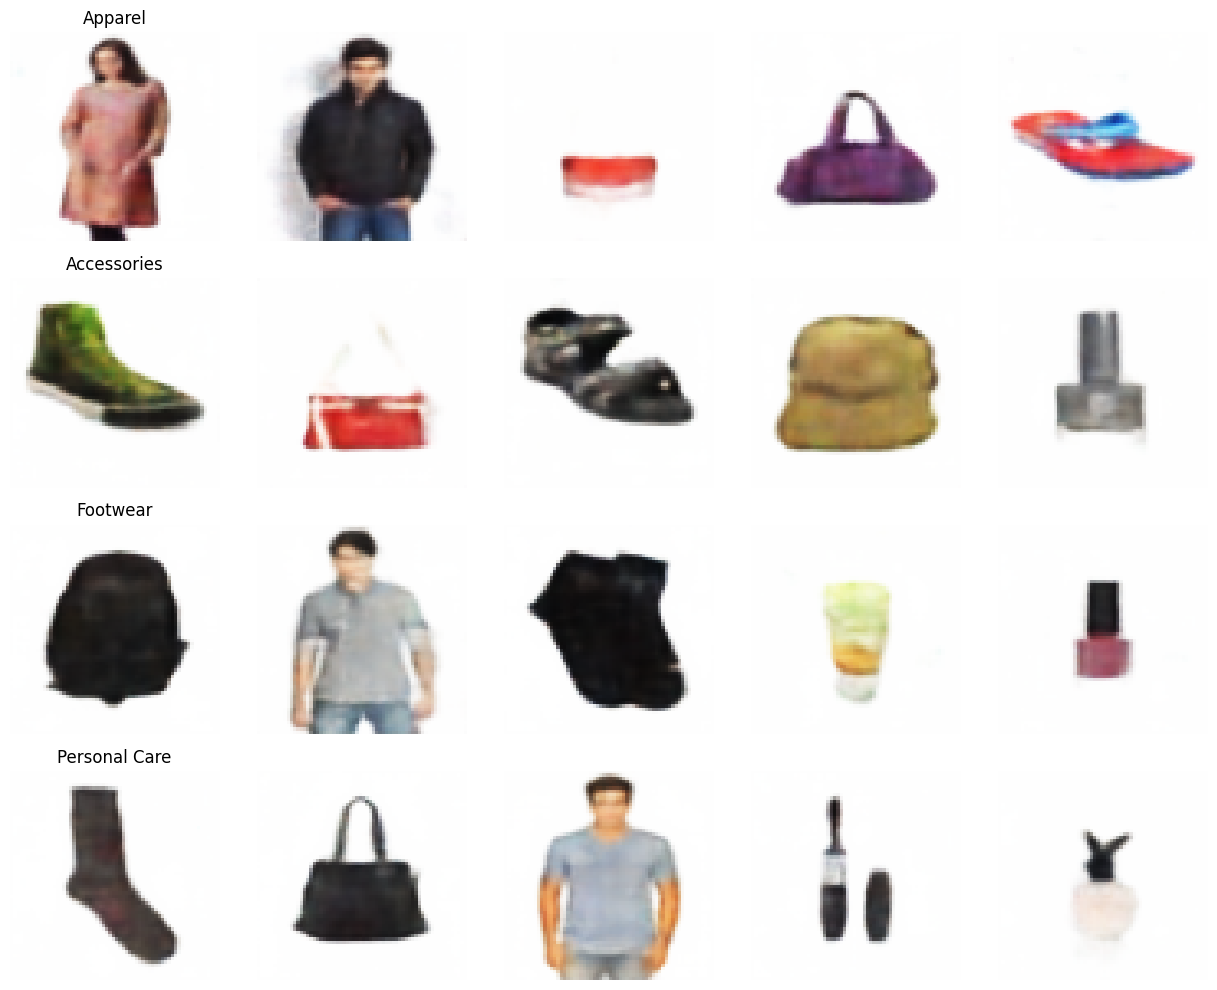

In [ ]:
generate_unfiltered_grid(
    class_names=["Apparel", "Accessories", "Footwear", "Personal Care"],
    encoder=encoder,
    model=model,
    dataloader=dataloader,
    samples_per_class=5,
    real_z=True
)

In [ ]:
import random

def generate_one_image_unfiltered(cat_name, encoder, model, dataloader=None, real_z=True):
    import matplotlib.pyplot as plt
    model.eval()

    # Prepare conditional vector
    label_vec = pd.DataFrame([[cat_name]], columns=encoder.feature_names_in_)
    cond = torch.tensor(encoder.transform(label_vec), dtype=torch.float32).to(device)

    # Sample latent vector from a random batch if real_z=True
    if real_z and dataloader is not None:
        batches = list(dataloader)
        img_batch, cond_batch, _ = random.choice(batches)
        img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)

        mu, logvar = model.encode(img_batch, cond_batch)
        z = mu + 0.1 * torch.randn_like(mu)
        z = z[torch.randint(0, z.size(0), (1,))]
    else:
        z = torch.randn(1, model.latent_dim).to(cond.device)

    with torch.no_grad():
        sample = model.decode(z, cond).cpu()[0]

    # Plot
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(sample.permute(1, 2, 0))
    plt.title(f"{cat_name}")
    plt.axis("off")
    plt.show()

    return sample

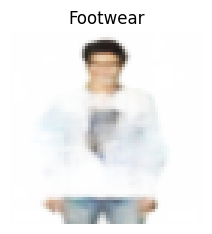

tensor([[[0.9994, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9998],
         [0.9999, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9999, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9994]],

        [[0.9994, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9999, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [0.9999, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9995]],

        [[0.9994, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9998],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [ ]:
generate_one_image_unfiltered(
    cat_name="Footwear",
    encoder=encoder,
    model=model,
    dataloader=dataloader,
    real_z=True
)

In [ ]:
def generate_filtered_grid(class_names, encoder, model, classifier, label_encoder, dataloader=None,
                           samples_per_class=4, max_attempts=500, real_z=True):
    import matplotlib.pyplot as plt
    model.eval()
    classifier.eval()

    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2.5, num_classes * 2.5))

    dataloader_cycle = cycle(dataloader)

    for i, cat_name in enumerate(class_names):
        label_vec = pd.DataFrame([[cat_name]], columns=encoder.feature_names_in_)
        cond = torch.tensor(encoder.transform(label_vec), dtype=torch.float32).to(device)

        label_idx = list(label_encoder.classes_).index(cat_name)

        valid_imgs = []
        attempts = 0

        if real_z and dataloader is not None:
            img_batch, cond_batch, _ = next(dataloader_cycle)
            img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)
            mu, logvar = model.encode(img_batch[:samples_per_class], cond_batch[:samples_per_class])
            z_base = mu + 0.3 * torch.randn_like(mu)
        else:
            z_base = torch.randn(samples_per_class, model.latent_dim).to(device)

        while len(valid_imgs) < samples_per_class and attempts < max_attempts:
            img_batch, cond_batch, _ = next(dataloader_cycle)
            img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)

            mu, logvar = model.encode(img_batch, cond_batch)
            z_sample = mu + 0.1 * torch.randn_like(mu)
            z = z_sample[torch.randint(0, z_sample.size(0), (1,))]

            with torch.no_grad():
                sample = model.decode(z, cond[:1]).cpu()
                logits = classifier(sample.to(cond.device))
                pred = torch.argmax(logits, dim=1).item()

            if pred == label_idx:
                valid_imgs.append(sample[0])
            attempts += 1

        for j in range(samples_per_class):
            if j < len(valid_imgs):
                axes[i, j].imshow(valid_imgs[j].permute(1, 2, 0))
            else:
                axes[i, j].text(0.5, 0.5, "X", ha='center', va='center', fontsize=18)
            axes[i, j].axis("off")

        axes[i, 0].set_title(cat_name)

    plt.tight_layout()
    plt.show()


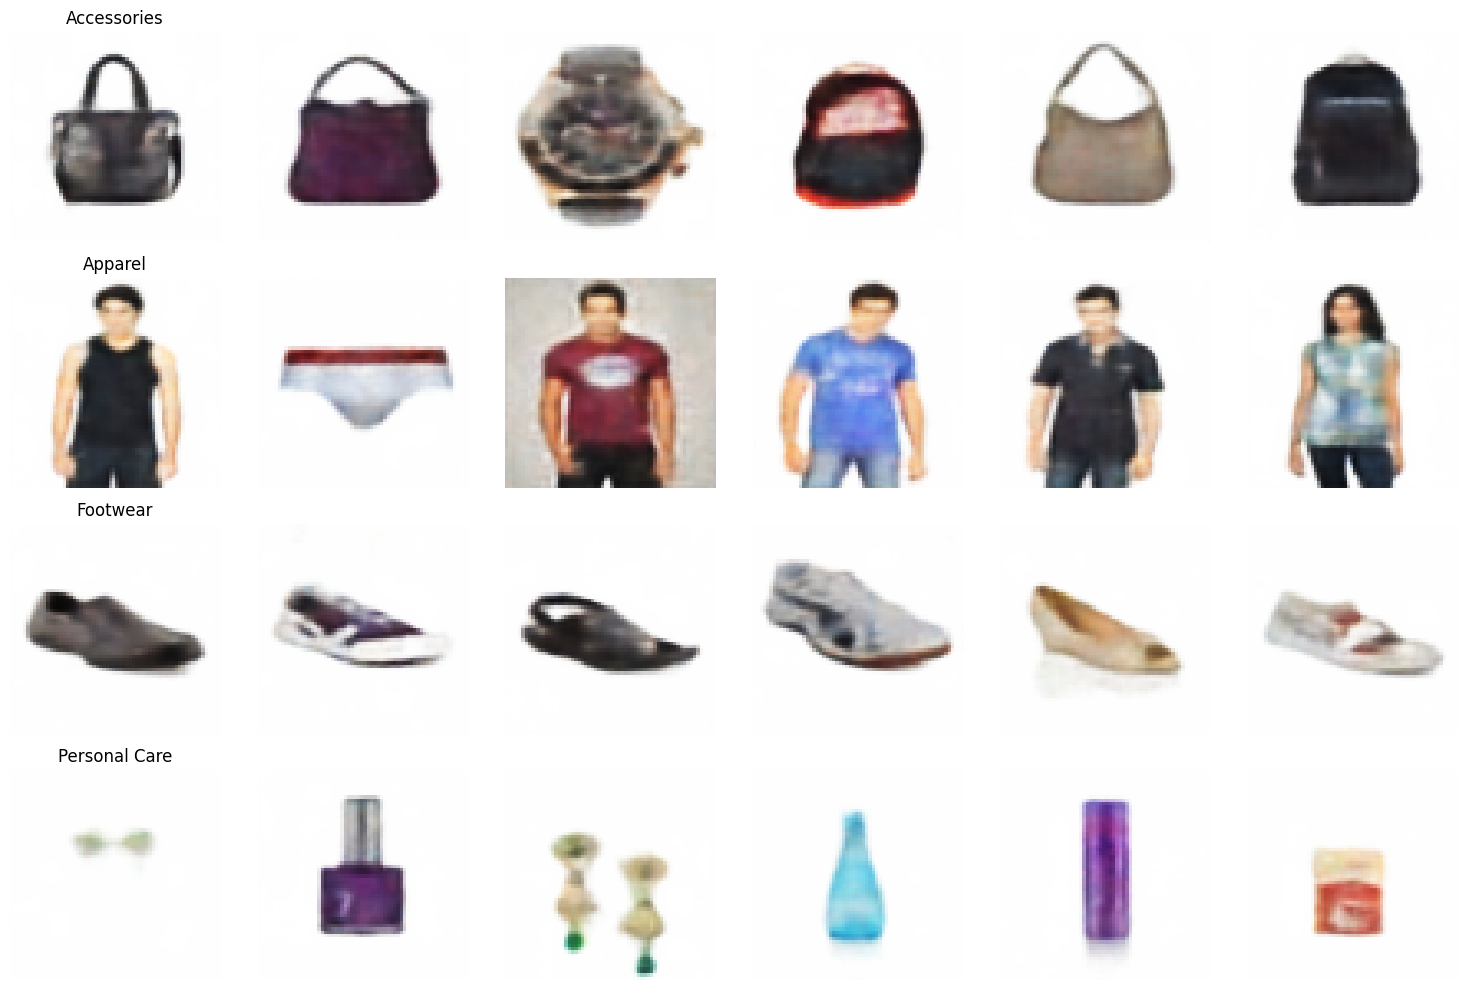

In [ ]:
class_names = list(label_encoder.classes_)

generate_filtered_grid(
    class_names=class_names,
    encoder=encoder,
    model=model,
    classifier=classifier,
    label_encoder=label_encoder,
    dataloader=dataloader,
    samples_per_class=6,
    max_attempts=100,
    real_z=True
)


In [ ]:
import matplotlib.pyplot as plt

def generate_one_filtered_image(cat_name, encoder, model, classifier, label_encoder,
                                dataloader=None, max_attempts=1000, real_z=True):

    model.eval()
    classifier.eval()

    label_vec_df = pd.DataFrame([[cat_name]], columns=encoder.feature_names_in_)
    cond = torch.tensor(encoder.transform(label_vec_df), dtype=torch.float32).to(device)

    label_idx = list(label_encoder.classes_).index(cat_name)

    dataloader_cycle = cycle(dataloader) if real_z and dataloader is not None else None

    for attempt in range(max_attempts):
        if real_z and dataloader_cycle is not None:
            img_batch, cond_batch, _ = next(dataloader_cycle)
            img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)
            mu, logvar = model.encode(img_batch, cond_batch)
            z_sample = mu + 0.1 * torch.randn_like(mu)
            z = z_sample[torch.randint(0, z_sample.size(0), (1,))]
        else:
            z = torch.randn(1, model.latent_dim).to(cond.device)

        with torch.no_grad():
            sample = model.decode(z, cond).cpu()
            logits = classifier(sample.to(cond.device))
            pred = torch.argmax(logits, dim=1).item()

        if pred == label_idx:
            plt.figure(figsize=(2.5, 2.5))
            plt.imshow(sample[0].permute(1, 2, 0))
            plt.title(f"{cat_name}")
            plt.axis("off")
            plt.show()
            return sample[0]

    print(f"⚠️ No valid image generated for '{cat_name}' in {max_attempts} attempts.")
    return None


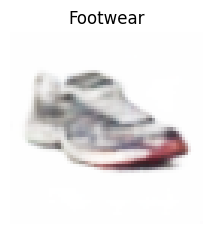

tensor([[[0.9974, 0.9998, 0.9998,  ..., 0.9999, 0.9999, 0.9982],
         [0.9996, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9999, 1.0000, 1.0000,  ..., 0.9999, 1.0000, 0.9999],
         ...,
         [0.9994, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9997, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9997],
         [0.9975, 0.9998, 0.9999,  ..., 0.9997, 0.9992, 0.9941]],

        [[0.9972, 0.9998, 0.9998,  ..., 0.9999, 0.9998, 0.9985],
         [0.9996, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9999, 1.0000, 1.0000,  ..., 0.9999, 0.9999, 0.9999],
         ...,
         [0.9990, 0.9999, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9996, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9996],
         [0.9978, 0.9998, 0.9998,  ..., 0.9996, 0.9986, 0.9906]],

        [[0.9972, 0.9997, 0.9998,  ..., 0.9999, 0.9998, 0.9980],
         [0.9996, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9999, 1.0000, 1.0000,  ..., 0.9999, 1.0000, 0.

In [ ]:
generate_one_filtered_image(
    cat_name="Footwear",
    encoder=encoder,
    model=model,
    classifier=classifier,
    label_encoder=label_encoder,
    dataloader=dataloader,
    real_z=True
)

### Evaluation: Frechet Inception Distance (FID)

In [ ]:
!pip install torchmetrics clean-fid

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 55.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
# import shutil

# shutil.rmtree("/content/real_apparel_images")
# shutil.rmtree("/content/generated_apparel_images")

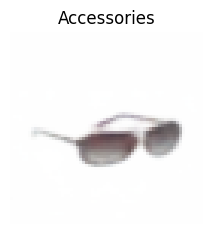

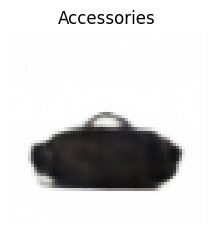

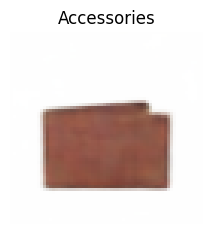

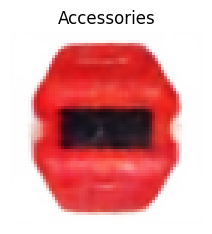

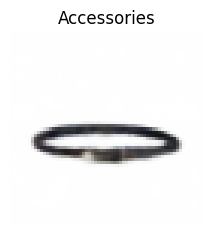

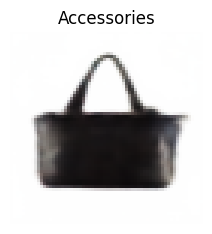

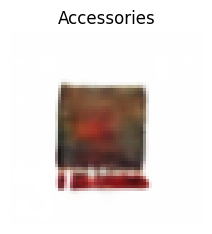

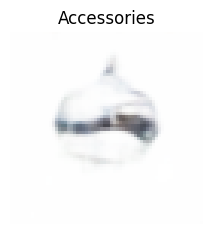

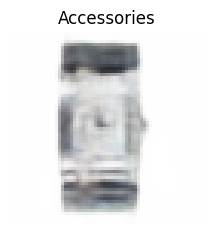

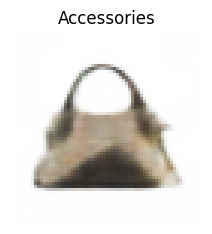

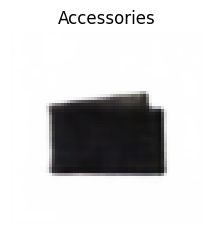

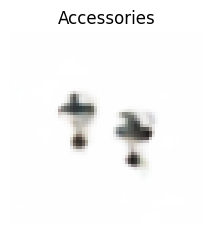

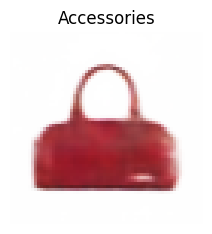

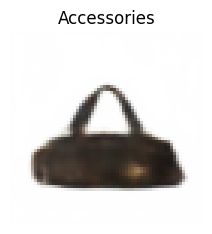

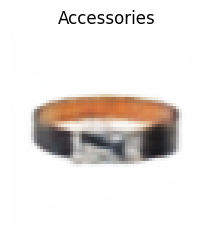

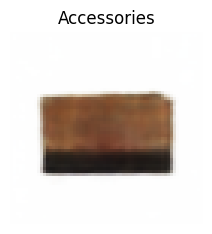

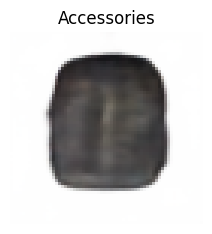

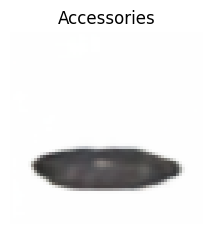

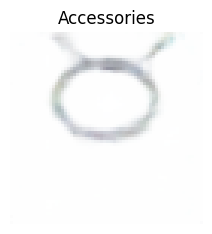

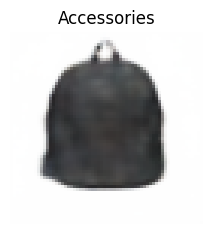

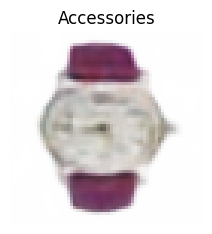

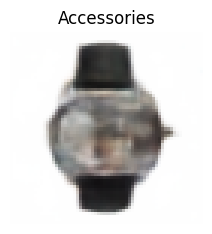

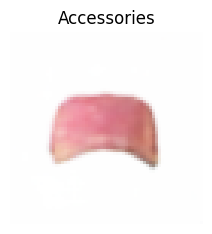

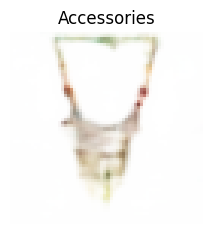

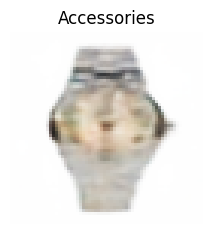

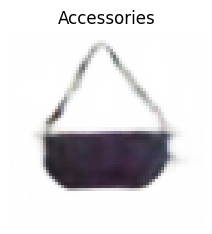

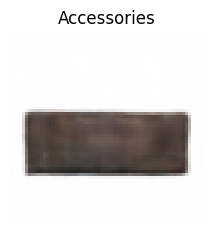

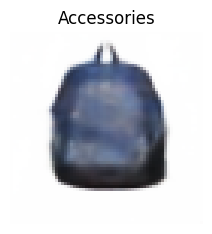

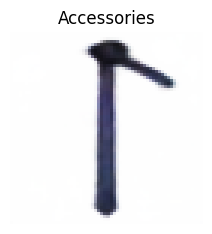

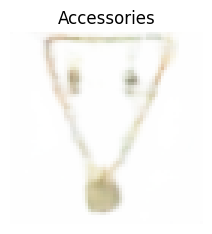

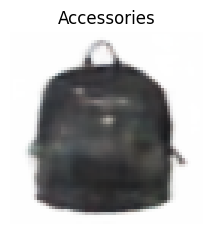

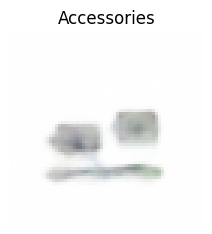

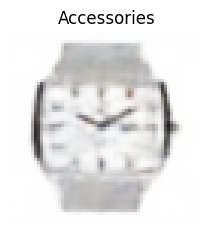

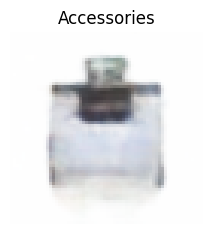

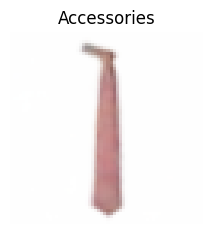

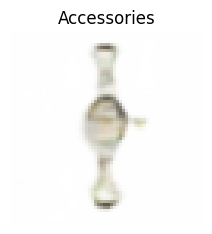

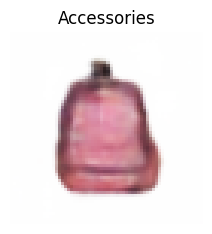

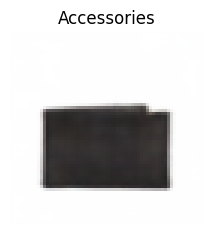

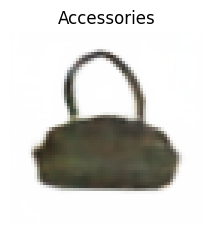

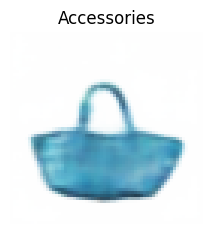

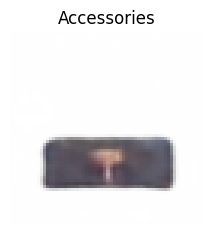

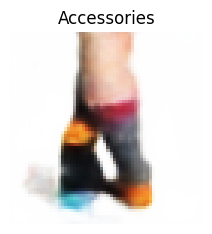

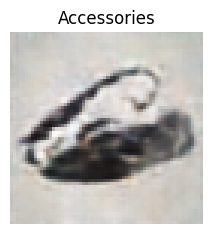

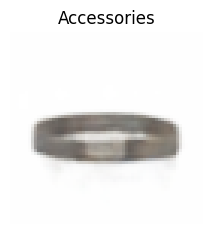

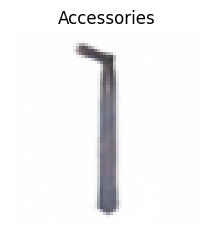

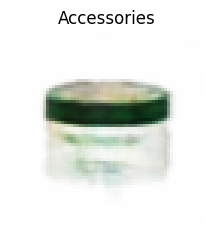

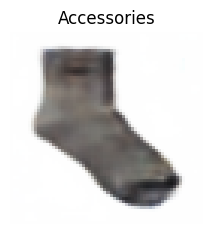

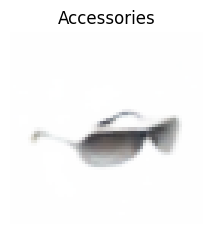

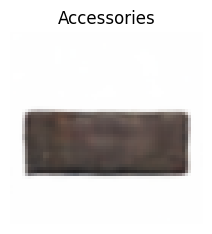

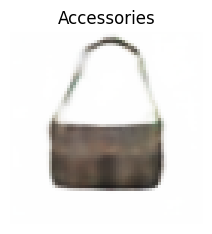

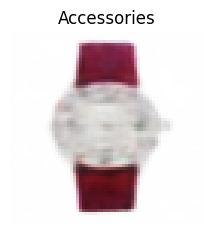

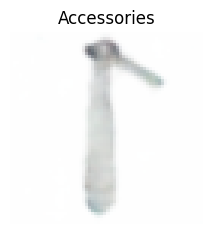

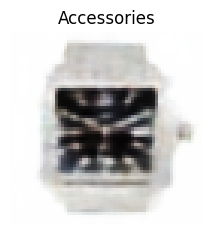

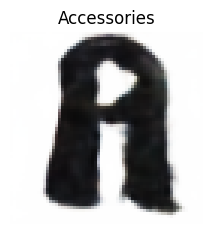

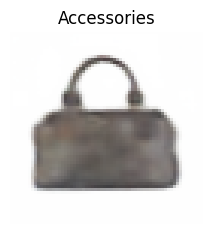

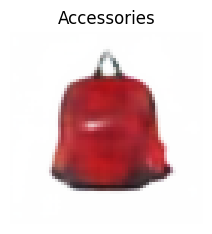

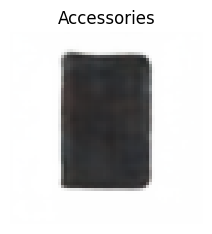

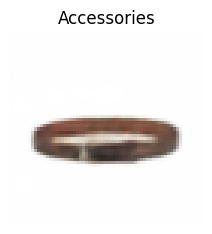

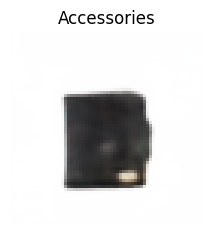

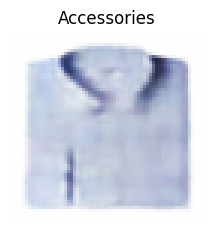

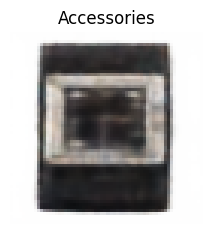

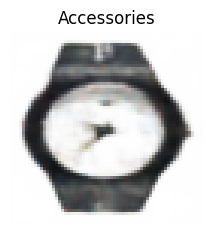

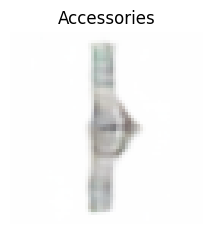

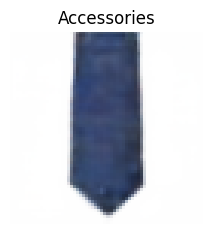

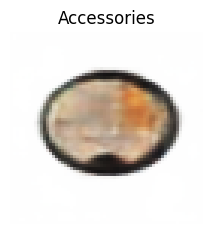

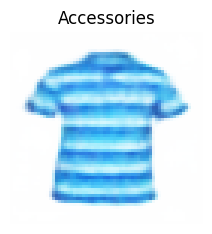

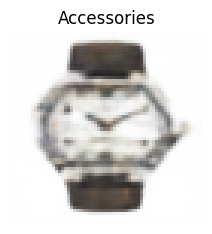

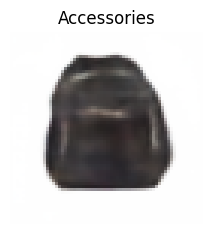

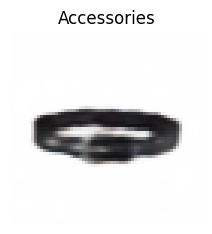

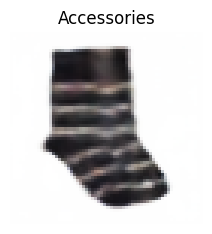

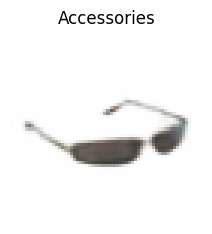

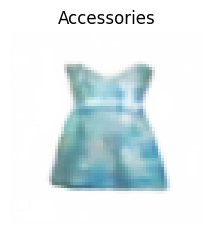

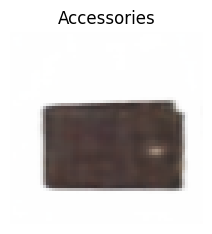

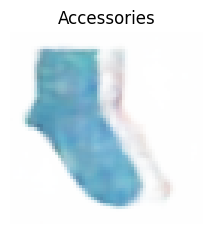

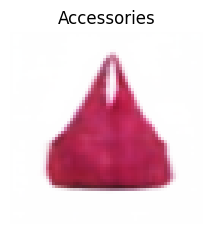

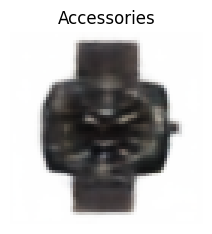

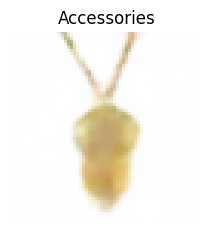

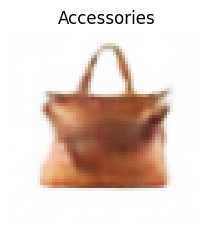

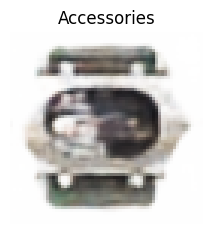

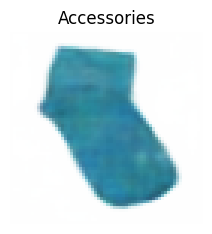

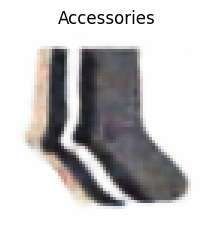

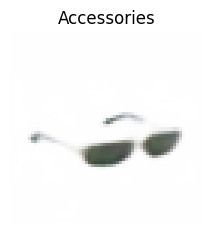

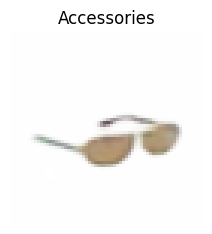

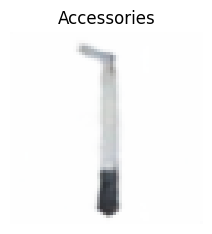

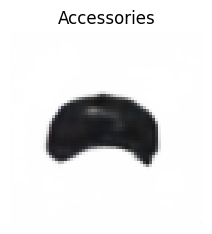

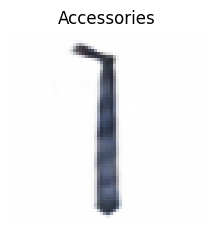

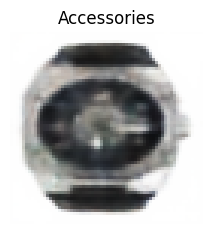

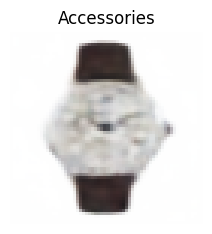

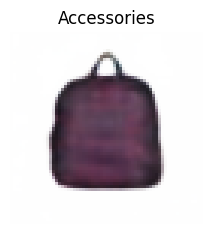

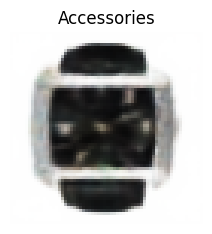

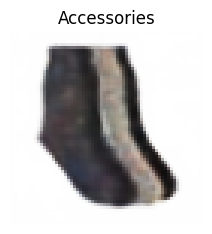

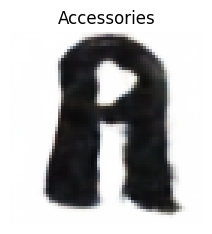

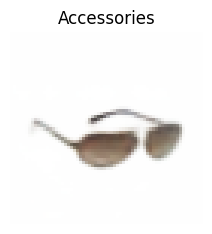

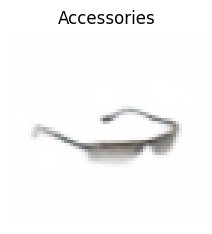

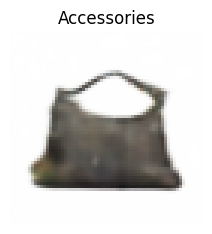

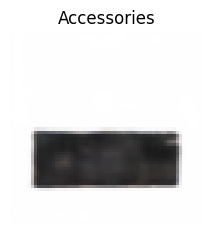

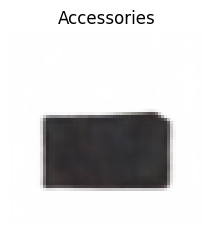

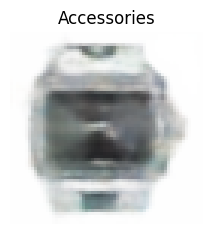

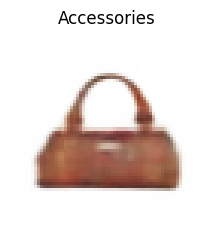

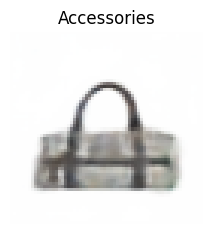

In [ ]:
import os
from torchvision.utils import save_image
from cleanfid import fid

category = "Accessories"
num_images = 100
save_dir = "fid_generated_filtered"

# --- Create folder ---
os.makedirs(save_dir, exist_ok=True)

# --- Generate and save ---
count = 0
while count < num_images:
    img = generate_one_filtered_image(
        cat_name=category,
        encoder=encoder,
        model=model,
        classifier=classifier,
        label_encoder=label_encoder,
        dataloader=dataloader,
        real_z=True,
        max_attempts=500
    )
    if img is not None:
        save_image(img, os.path.join(save_dir, f"{count}.png"))
        count += 1

In [ ]:
# import shutil

# shutil.rmtree('/content/fid_real_images')
# shutil.rmtree('/content/fid_generated_filtered')

In [ ]:
from torchvision.transforms import Resize, ToTensor
from PIL import Image

real_dir = "fid_real_images"
os.makedirs(real_dir, exist_ok=True)

# Sample real images of same class
category_idx = list(label_encoder.classes_).index(category)
real_imgs = df[df["masterCategory"] == category_idx].sample(100)
for i, row in real_imgs.iterrows():
    img = Image.open(os.path.join(image_dir, row["image"])).convert("RGB")
    img = Resize((64, 64))(img)
    img = ToTensor()(img)
    save_image(img, os.path.join(real_dir, f"{i}.png"))


In [ ]:
fid_score = fid.compute_fid(real_dir, save_dir)
print(f"FID Score: {fid_score:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute FID between two folders
Found 100 images in the folder fid_real_images


FID fid_real_images : 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Found 100 images in the folder fid_generated_filtered


FID fid_generated_filtered : 100%|██████████| 4/4 [00:05<00:00,  1.40s/it]


FID Score: 157.1017


### Saving Model & encoders for inference time

In [ ]:
torch.save(model.state_dict(), "cvae_model.pt")

In [ ]:
import joblib
joblib.dump(encoder, "onehot_encoder.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']

In [ ]:
torch.save(classifier.state_dict(), "classifier.pt")

In [ ]:
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)


### For Inferencing

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.nn as nn
import torch.nn.functional as F

class CVAE(nn.Module):
    def __init__(self, condition_dim, latent_dim=256):
        super(CVAE, self).__init__()
        self.condition_dim = condition_dim
        self.latent_dim = latent_dim

        # --- Encoder ---
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 4x4
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )

        self.fc_mu = nn.Linear(256 * 4 * 4 + condition_dim, latent_dim)
        self.fc_logvar = nn.Linear(256 * 4 * 4 + condition_dim, latent_dim)

        # --- Decoder ---
        self.decoder_input = nn.Linear(latent_dim + condition_dim, 256 * 4 * 4)

        # Inject condition into the decoder through the first layer (256 + cond_dim)
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(256 + condition_dim, 128, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 64x64
            nn.Sigmoid()
        )

    def encode(self, x, cond):
        x = self.encoder_conv(x)
        x = x.view(x.size(0), -1)
        x_cond = torch.cat([x, cond], dim=1)
        mu = self.fc_mu(x_cond)
        logvar = self.fc_logvar(x_cond)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, cond):
        z_cond = torch.cat([z, cond], dim=1)
        x = self.decoder_input(z_cond)
        x = x.view(-1, 256, 4, 4)

        # Deep conditioning: broadcast cond and concat
        cond_expand = cond.unsqueeze(2).unsqueeze(3).expand(-1, self.condition_dim, 4, 4)
        x = torch.cat([x, cond_expand], dim=1)

        return self.decoder_conv(x)

    def forward(self, x, cond):
        mu, logvar = self.encode(x, cond)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z, cond)
        return recon, mu, logvar

    def sample(self, cond, n_samples=1):
        z = torch.randn(n_samples, self.latent_dim).to(cond.device)
        cond = cond.repeat(n_samples, 1) if cond.dim() == 1 else cond
        return self.decode(z, cond)

In [ ]:
class MasterCategoryClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MasterCategoryClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
import os
import torch
import joblib
import json
from torchvision.utils import save_image
from torchvision import transforms
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder = joblib.load("onehot_encoder.pkl")
label_encoder = joblib.load("label_encoder.pkl")

with open("class_names.json") as f:
    class_names = json.load(f)

condition_dim = len(encoder.get_feature_names_out())
latent_dim = 256

model = CVAE(condition_dim=condition_dim, latent_dim=latent_dim).to(device)
model.load_state_dict(torch.load("cvae_model.pt", map_location=device))
model.eval()

classifier = MasterCategoryClassifier(num_classes=len(label_encoder.classes_)).to(device)
classifier.load_state_dict(torch.load("classifier.pt", map_location=device))
classifier.eval()

MasterCategoryClassifier(
  (model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=128, out_features=4, bias=True)
  )
)

In [ ]:
def generate_filtered_grid(class_names, encoder, model, classifier, label_encoder, dataloader=None,
                           samples_per_class=4, max_attempts=500, real_z=True):
    import matplotlib.pyplot as plt
    model.eval()
    classifier.eval()

    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 2.5, num_classes * 2.5))

    dataloader_cycle = cycle(dataloader)

    for i, cat_name in enumerate(class_names):
        label_vec = pd.DataFrame([[cat_name]], columns=encoder.feature_names_in_)
        cond = torch.tensor(encoder.transform(label_vec), dtype=torch.float32).to(device)

        label_idx = list(label_encoder.classes_).index(cat_name)

        valid_imgs = []
        attempts = 0

        if real_z and dataloader is not None:
            img_batch, cond_batch, _ = next(dataloader_cycle)
            img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)
            mu, logvar = model.encode(img_batch[:samples_per_class], cond_batch[:samples_per_class])
            z_base = mu + 0.3 * torch.randn_like(mu)
        else:
            z_base = torch.randn(samples_per_class, model.latent_dim).to(device)

        while len(valid_imgs) < samples_per_class and attempts < max_attempts:
            # 🔀 Random batch each attempt
            img_batch, cond_batch, _ = next(dataloader_cycle)
            img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)

            mu, logvar = model.encode(img_batch, cond_batch)
            z_sample = mu + 0.1 * torch.randn_like(mu)
            z = z_sample[torch.randint(0, z_sample.size(0), (1,))]

            with torch.no_grad():
                sample = model.decode(z, cond[:1]).cpu()
                logits = classifier(sample.to(cond.device))
                pred = torch.argmax(logits, dim=1).item()

            if pred == label_idx:
                valid_imgs.append(sample[0])
            attempts += 1

        for j in range(samples_per_class):
            if j < len(valid_imgs):
                axes[i, j].imshow(valid_imgs[j].permute(1, 2, 0))
            else:
                axes[i, j].text(0.5, 0.5, "X", ha='center', va='center', fontsize=18)
            axes[i, j].axis("off")

        axes[i, 0].set_title(cat_name)

    plt.tight_layout()
    plt.show()


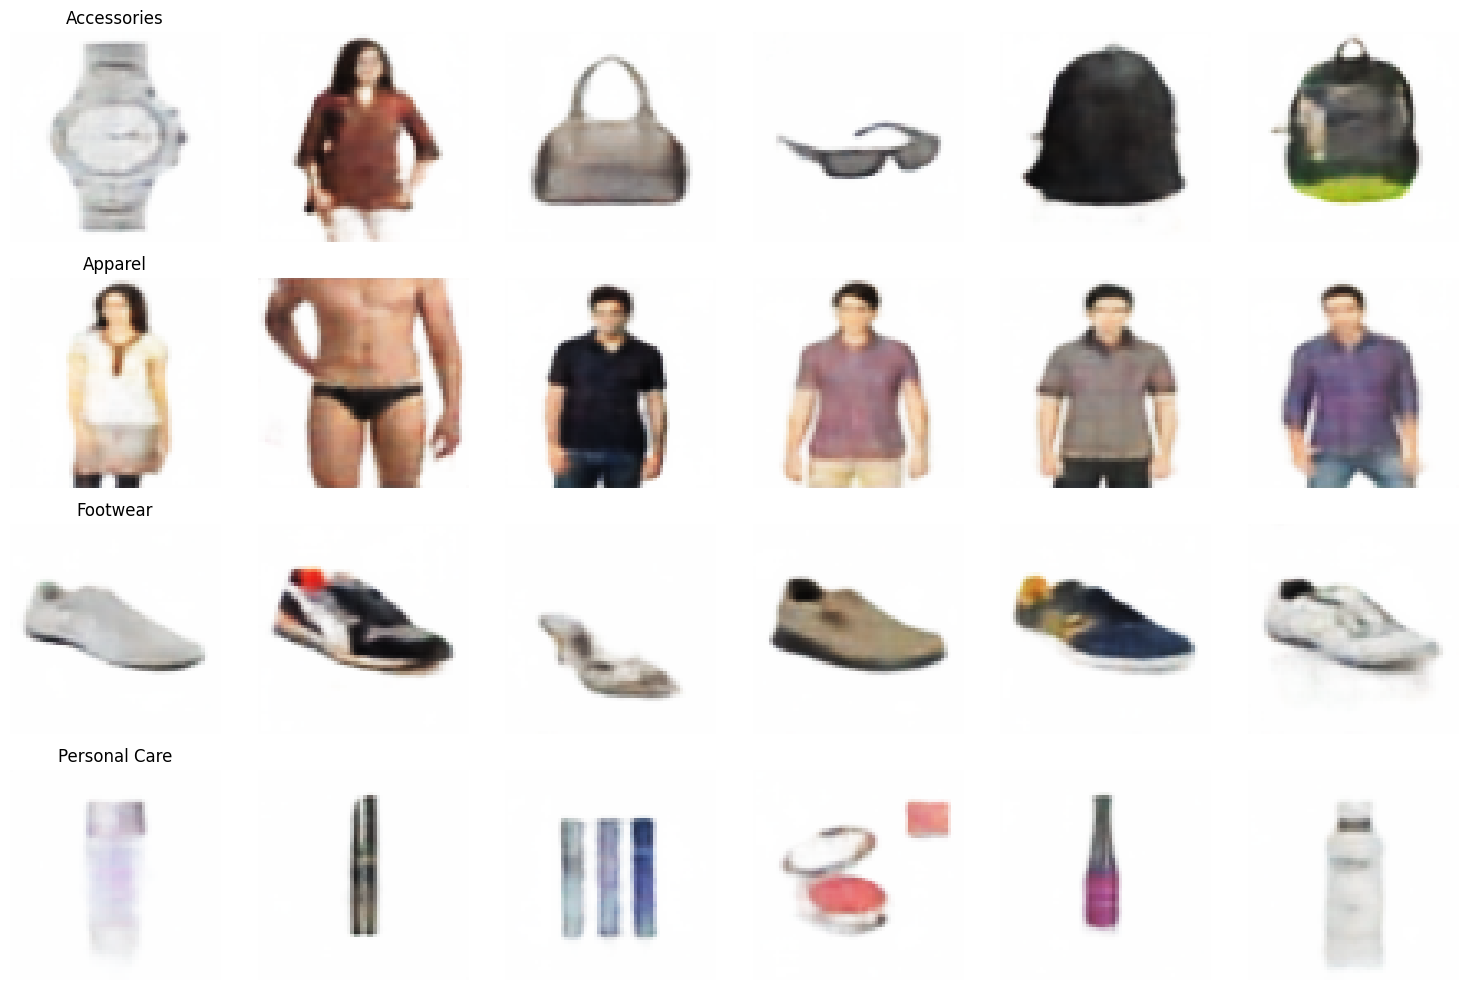

In [ ]:
class_names = list(label_encoder.classes_)

generate_filtered_grid(
    class_names=class_names,
    encoder=encoder,
    model=model,
    classifier=classifier,
    label_encoder=label_encoder,
    dataloader=dataloader,
    samples_per_class=6,
    max_attempts=100,
    real_z=True
)


In [ ]:
import matplotlib.pyplot as plt

def generate_one_filtered_image(cat_name, encoder, model, classifier, label_encoder,
                                dataloader=None, max_attempts=1000, real_z=True):

    model.eval()
    classifier.eval()

    label_vec_df = pd.DataFrame([[cat_name]], columns=encoder.feature_names_in_)
    cond = torch.tensor(encoder.transform(label_vec_df), dtype=torch.float32).to(device)

    label_idx = list(label_encoder.classes_).index(cat_name)

    dataloader_cycle = cycle(dataloader) if real_z and dataloader is not None else None

    for attempt in range(max_attempts):
        if real_z and dataloader_cycle is not None:
            img_batch, cond_batch, _ = next(dataloader_cycle)
            img_batch, cond_batch = img_batch.to(device), cond_batch.to(device)
            mu, logvar = model.encode(img_batch, cond_batch)
            z_sample = mu + 0.1 * torch.randn_like(mu)
            z = z_sample[torch.randint(0, z_sample.size(0), (1,))]
        else:
            z = torch.randn(1, model.latent_dim).to(cond.device)

        with torch.no_grad():
            sample = model.decode(z, cond).cpu()
            logits = classifier(sample.to(cond.device))
            pred = torch.argmax(logits, dim=1).item()

        if pred == label_idx:
            plt.figure(figsize=(2.5, 2.5))
            plt.imshow(sample[0].permute(1, 2, 0))
            plt.title(f"{cat_name}")
            plt.axis("off")
            plt.show()
            return sample[0]

    print(f"⚠️ No valid image generated for '{cat_name}' in {max_attempts} attempts.")
    return None


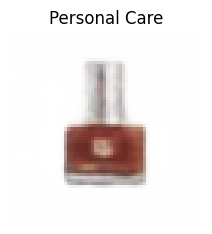

tensor([[[0.9997, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9995],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9999, 1.0000, 1.0000,  ..., 0.9999, 0.9999, 0.9999],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9995, 1.0000, 0.9999,  ..., 0.9998, 0.9998, 0.9989]],

        [[0.9997, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9997],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.9998, 1.0000, 1.0000,  ..., 0.9999, 0.9999, 0.9999],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9999],
         [0.9996, 1.0000, 0.9999,  ..., 0.9998, 0.9998, 0.9990]],

        [[0.9997, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9996],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.

In [ ]:
generate_one_filtered_image(
    cat_name="Personal Care",
    encoder=encoder,
    model=model,
    classifier=classifier,
    label_encoder=label_encoder,
    dataloader=dataloader,
    real_z=True
)